This notebook demonstrates how to use the discrete cosine transform tool in orqviz to analyze quantum circuits. This example uses the *Quantum Approximate Optimization Algorithm* (QAOA).

DCT is used to isolate the frequencies of cosine wave components used to make up a loss function. It is similar to a discrete fourier transform, but it breaks up each dimension of a function into its cosine components only (unlike discrete fourier transform which breaks up a complex-valued function into its cosine and sine components).

In [1]:
import numpy as np
import orqviz
import matplotlib.pyplot as plt
from openfermion import IsingOperator
from zquantum.qaoa.ansatzes import QAOAFarhiAnsatz
from qequlacs import QulacsSimulator
from zquantum.core.utils import create_symbols_map

Start with a simple example: loss function is a simple cosine function with frequency 3.

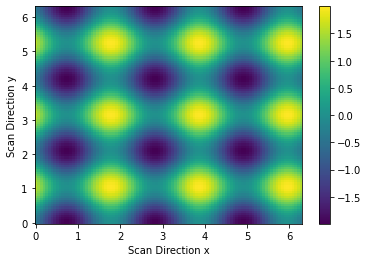

In [5]:
def loss_function(pars):
    return np.sum(np.cos(3 * pars))


n_params = 2
params = np.random.uniform(-np.pi, np.pi, size=n_params)
dir1 = np.array([1.0, 0.0])
dir2 = np.array([0.0, 1.0])
end_points = (0, 2 * np.pi)

res = 100
scan2D_result = orqviz.scans.perform_2D_scan(
    params,
    loss_function,
    direction_x=dir1,
    direction_y=dir2,
    n_steps_x=res,
    end_points_x=end_points,
)
orqviz.scans.plot_2D_scan_result(scan2D_result)

plt.show()
plt.clf()
plt.close()

Just like we expect: it is periodic with each period repeating about 3 times across the 0 - 2pi range. Now, let's run DCT on it.

2.0


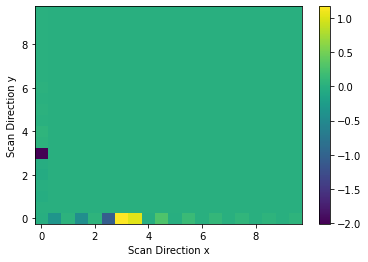

In [6]:
dct_res = 10
dct_result = orqviz.dct.scan_2D_dct(
    params,
    loss_function,
    direction_x=dir1,
    direction_y=dir2,
    n_steps_x=res,
    end_points_x=end_points,
    dct_resolution_x=dct_res,
)
orqviz.scans.plot_2D_scan_result(dct_result)

Since the function is a simple cosine in both the x and y direction, we see a single spike in both directions reflected in the DCT result. The spikes are around where 3 is. The majority of frequencies have an amplitude of 0. We're not entirely sure what the ripples going outwards from the spike means, but we guess that the ripples are an artifact from the relatively low resolution. We guess that in a perfect smooth cosine transform rather than a discrete one, we'd have only isolated spikes at 3. 

The fact that all the non-zero values are concentrated near the boundaries (where either the x or the y component of the frequency is 0) mean that there aren't any cos(x) * cos(y) components of this pure cosine function.

Now, let's try DCT on some quantum circuits!

In [2]:

def plot_function_and_dct(hamiltonian: IsingOperator, res: int, dct_res=20, n_layers=1, dir1=np.array([1.0, 0.0]), dir2=np.array([0.0, 1.0])):
    """For functions with 2 params"""
    params = np.random.uniform(-np.pi, np.pi, size=n_layers * 2)
    end_points = (0, 2 * np.pi)

    def loss_function(pars: np.ndarray) -> float:
        sim = QulacsSimulator()
        # create circuit
        ansatz = QAOAFarhiAnsatz(n_layers, hamiltonian)
        circuit = ansatz.parametrized_circuit
        circuit_symbols = circuit.free_symbols

        # calculate the expectation value relative to parameters
        symbols_map = create_symbols_map(circuit_symbols, pars)
        circuit = circuit.bind(symbols_map)
        return sim.get_exact_expectation_values(circuit, hamiltonian).values.sum()

    scan2D_result = orqviz.scans.perform_2D_scan(
        params,
        loss_function,
        direction_x=dir1,
        direction_y=dir2,
        n_steps_x=res,
        end_points_x=end_points,
    )
    orqviz.scans.plot_2D_scan_result(scan2D_result)

    plt.show()
    plt.clf()
    plt.close()


    dct_result = orqviz.dct.scan_2D_dct(
        params,
        loss_function,
        direction_x=dir1,
        direction_y=dir2,
        n_steps_x=res,
        end_points_x=end_points,
        dct_resolution_x=dct_res,
    )

    orqviz.scans.plot_2D_scan_result(dct_result)
    plt.show()
    plt.clf()
    plt.close()


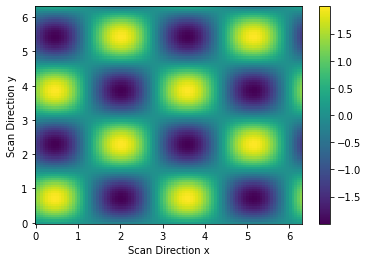

2.0


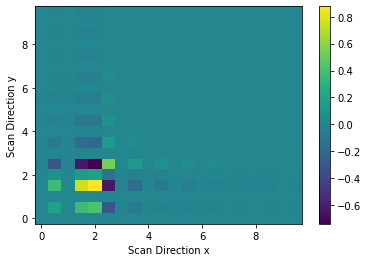

In [8]:
sum_hamiltonian = IsingOperator("Z0") + IsingOperator("Z1")
plot_function_and_dct(sum_hamiltonian, res=100, dct_res=10)

The first plot is of the landscape of the function, the second one is of the DCT result. Now, we reflected in the DCT result that most components of this loss function involve some combination of cos(x) and cos(y) terms multiplied together.

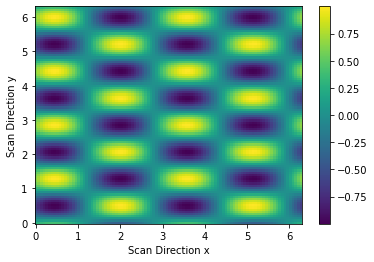

2.0


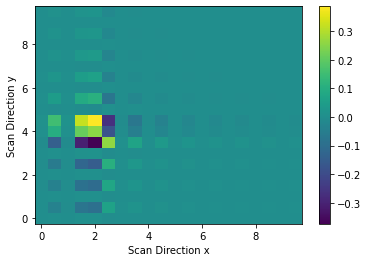

In [9]:
product_hamiltonian = IsingOperator("Z0 Z1")
plot_function_and_dct(product_hamiltonian, res=100, dct_res=10)

Here, we can see from the cosine tranform the function has around twice as much freqency in the y-direction compared to the x-direction, which is reflected in the plot which looks like it's horizontally "compressed" by a factor of 2 from the previous one. The exact x and y values of the DCT finalized result represent the number of periods over the 0 - 2pi range.

Now, we'll try with a funkier hamiltonian.

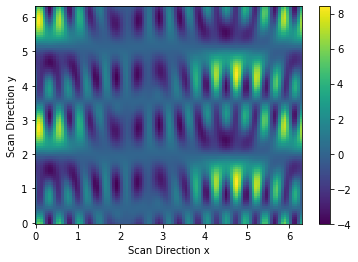

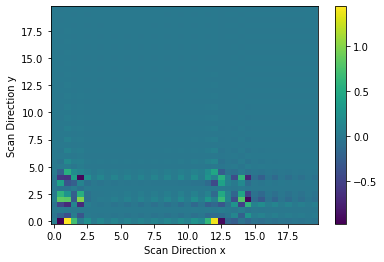

In [3]:
hamiltonian_1 = (
    (-2.75) * IsingOperator("Z0")
    + (-3.25) * IsingOperator("Z1")
    + (3.75) * IsingOperator("Z0 Z1")
)

plot_function_and_dct(hamiltonian_1, res=100)

This hamiltonian has 2 clusters of activity at 2 different frequencies of 2 and 12 in the x-direction. You can see this reflected in the graph, where in the x-direction, there is a higher frequency ripple by the contrasting colours and a lower frequency one that goes up and down.

Finally, we can try DCT on some loss functions with more than two parameters. This is done by using orqviz to get a 2D cross section of the loss function landscape and running DCT on that.

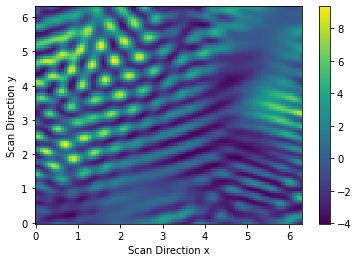

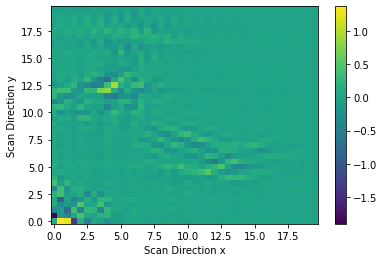

In [4]:
n_layers = 2 
n_params = n_layers * 2
dir1 = orqviz.geometric.get_random_normal_vector(n_params)
dir2 = orqviz.geometric.get_random_orthonormal_vector(dir1)
plot_function_and_dct(hamiltonian_1, res=100, dct_res=20, n_layers=n_layers, dir1=dir1, dir2=dir2)

We're currently not very sure how to make this multi-dimensional analysis more useful.